# DEA of English schools

Use the DEA module to examine the relative performance of English schools.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydea as dea
import pandas as pd

%matplotlib inline

##Import the data

Retrieve results and financial data from the DfE website and read in to a pandas DataFrame object. For now, ignore the list of open academies.

 - [School performance tables and financial data](http://www.education.gov.uk/schools/performance/download_data.html)
 - [Open academies](https://www.gov.uk/government/publications/open-academies-and-academy-projects-in-development)

### Read data

In [2]:
import os
import pickle
import requests
from zipfile import ZipFile
from io import BytesIO

def cached_data(picklename, genfunc):
    cache_path = picklename + ".pickle"
    if not os.path.exists(cache_path):
        # The cache doesn't exist, create it and populate it
        result = genfunc() 
        cache_file = open(cache_path,'wb')
        # Write it to the result to the file as a pickled object
        # Use the binary protocol for better performance
        pickle.dump(result, cache_file, protocol=1)
        cache_file.close()
    return pickle.load(open(cache_path,'rb'))


#    These functions actually generates the data when it isn't cached.
#    The data generated is often expensive to compute so caching helps with performance.

def gen_results():
       
    #Results data    
    dfe_results_urls = ['http://www.education.gov.uk/schools/performance/download/csv/england_ks2.csv',
                    'http://www.education.gov.uk/schools/performance/download/csv/england_ks4.csv',
                    'http://www.education.gov.uk/schools/performance/download/csv/england_ks5.csv',
                    'http://www.education.gov.uk/schools/performance/download/csv/england_abs.csv',
                    'http://www.education.gov.uk/schools/performance/download/csv/england_cfr.csv',
                    'http://www.education.gov.uk/schools/performance/download/csv/england_swf.csv',
                    'http://www.education.gov.uk/schools/performance/download/csv/england_spine.csv',
                    'http://www.education.gov.uk/schools/performance/download/csv/england_census.csv']

    dfe_results_dfs = []
    for url in dfe_results_urls[0:1]:
        tmpdf = pd.read_csv(url, na_values=['PRI', 'SEC', 'NAT', 'NA', 'NP', 'SUPP', 'NE', 'NEW', 'LOWCOV'], index_col=4)
        dfe_results_dfs.append(tmpdf)
        
    return dfe_results_dfs

def gen_findat():
    
    #Financial data
    zipFileURL = "http://www.education.gov.uk/schools/performance/download/School_total_spend_2012-2013-Full_data_workbook.zip"

    DfEzip = requests.get(zipFileURL)
    DfEfindat = ZipFile(BytesIO(DfEzip.content), 'r')
    findat = pd.read_excel(DfEfindat.open(DfEfindat.namelist()[0]), 2,
                          skiprows=3,
                          index_col=6,
                          na_values=['PRI', 'SEC', 'NAT', 'NA', 'NP', 'SUPP', 'NE', 'NEW', 'LOWCOV'])

    return findat

dfe_results_dfs = cached_data("dfe_results", gen_results)
findat = cached_data("dfe_findat", gen_findat)

### Results data

In [3]:
ks2res = dfe_results_dfs[0]
ks2res.describe().T[:5]

,count,mean,std,min,25%,50%,75%,max
RECTYPE,16190,1.061519,0.278619,1,1.0,1.0,1.0,5
ALPHAIND,16036,30921.753430,17294.515442,20,15975.5,31525.0,45922.5,60290
LEA,16188,696.975908,262.743650,201,371.0,850.0,891.0,938
ESTAB,16036,2962.048017,1135.598625,2000,2127.0,2694.5,3344.0,7749
URN_AC,16036,3313.438202,21240.185772,0,0.0,0.0,0.0,140120


### Financial data

This is a fragile procedure with a lot of hard-coded parts. __Check the data before proceeding__.

In [4]:
findat.describe().T[:5]

,count,mean,std,min,25%,50%,75%,max
LA code,18114,701.145854,260.996499,201,372.00,850.0,891,938
Estab code,18114,3091.494645,1197.294631,2000,2165.00,2982.5,3424,7750
School DfE number,18114,7014550.035001,2609976.801063,2013614,3722104.25,8502749.5,8912894,9387022
School statutory low age,18114,4.692006,2.362017,2,3.00,4.0,5,14
School statutory high age,18114,11.402782,2.485372,5,11.00,11.0,11,19


### Merge datasets on school's URN

For now, deal with only primary schools and their KS2 results

In [5]:
prim_findat = findat[findat['Phase of education'] == 'Primary']
primdat = prim_findat.join(ks2res)
primdat.describe().T[:5]

,count,mean,std,min,25%,50%,75%,max
LA code,15615,705.823567,259.200834,201,373.0,850,891.0,938
Estab code,15615,2739.930772,693.918032,2000,2130.0,2508,3306.0,5949
School DfE number,15615,7060975.601601,2592077.227001,2013614,3732324.5,8503199,8913512.5,9383376
School statutory low age,15615,4.009478,1.105218,2,3.0,4,5.0,8
School statutory high age,15615,10.573999,1.169842,7,11.0,11,11.0,11


## DEA on primary schools

The DEA library does not yet account for exogenous characteristics. That is partially accounted for by using only value-added measures as outputs.

Metadata for all of the fields in the dataset is [here](http://www.education.gov.uk/schools/performance/metadata.html).

Inputs: 
 - Teaching Staff (£ per pupil)	
 - Supply Teachers (£ per pupil)	
 - Education Support Staff (£ per pupil)	
 - Premises (incl. Staff costs) (£ per pupil)	
 - Back Office (incl. Staff) (£ per pupil)	
 - Catering (incl. Staff costs) (£ per pupil)	
 - Other Staff Costs (£ per pupil)	
 - Energy (£ per pupil)	
 - Learning Resources (not ICT) (£ per pupil)	
 - ICT Learning Resources (£ per pupil)	
 - Bought in Professional Services (£ per pupil)	
 - Other expenditure (£ per pupil)

Outputs:
 - MVAMEAS
 - RVAMEAS
 - WVAMEAS

### Mung the data

Cut out the potential input and output columns. Drop anything with a `np.NaN` value. This will under-sample the data but should be enough to test the DEA algorithm against real data.

In [6]:
input_cols = [u'E01 Teaching Staff', u'E02 \nSupply teaching staff', u'E03 Education support staff', u'E04 Premises staff', u'E05 Administrative and clerical staff', u'E06 Catering staff', u'E07 \nCost of other staff', u'E08 Indirect employee expenses', u'E09 Development and training', u'E10 \nSupply teacher insurance', u'E11 \nStaff related insurance', u'E12 \nBuilding maintenance and improvement', u'E13 \nGrounds maintenance and improvement', u'E14 Cleaning and caretaking', u'E15 \nWater and sewerage', u'E16 \nEnergy', u'E17 \nRates', u'E18 \nOther occupation costs', u'E19 Learning resources (not ICT equipment)', u'E20 \nICT learning resources', u'E21 \nExam fees', u'E22 Administrative supplies', u'E23 \nOther insurance premiums', u'E24 Special facilities ', u'E25 Catering supplies', u'E26 Agency supply teaching staff', u'E27 \nBought in professional services – curriculum', u'E28 \nBought in professional services – other', u'E29 \nLoan interest', u'E31 Community focused school staff', u'E32 Community focused school costs']
output_cols = ['MVAMEAS', 'RVAMEAS', 'WVAMEAS', ]
inoutdat = primdat[input_cols + output_cols].dropna(how='any')
inoutdat.describe().T[:5]

,count,mean,std,min,25%,50%,75%,max
E01 Teaching Staff,433,1141533.493349,332241.644281,315772.00,883873.57,1106585.31,1326774.67,2438926.83
E02 \nSupply teaching staff,433,16601.393487,24743.625269,0.00,0.00,7232.29,23247.65,169148.44
E03 Education support staff,433,445495.999538,168205.591156,45273.94,321296.67,423777.00,540089.27,1105842.53
E04 Premises staff,433,68796.045081,35941.585199,0.00,56192.62,68928.79,86875.40,293417.51
E05 Administrative and clerical staff,433,107922.853926,46339.829420,0.00,79439.68,98027.43,125055.44,466979.23


_Why are there so few schools left after dropping missing data? Must be some common exclusion causing too many to be dropped._

#### Check distribution of the data

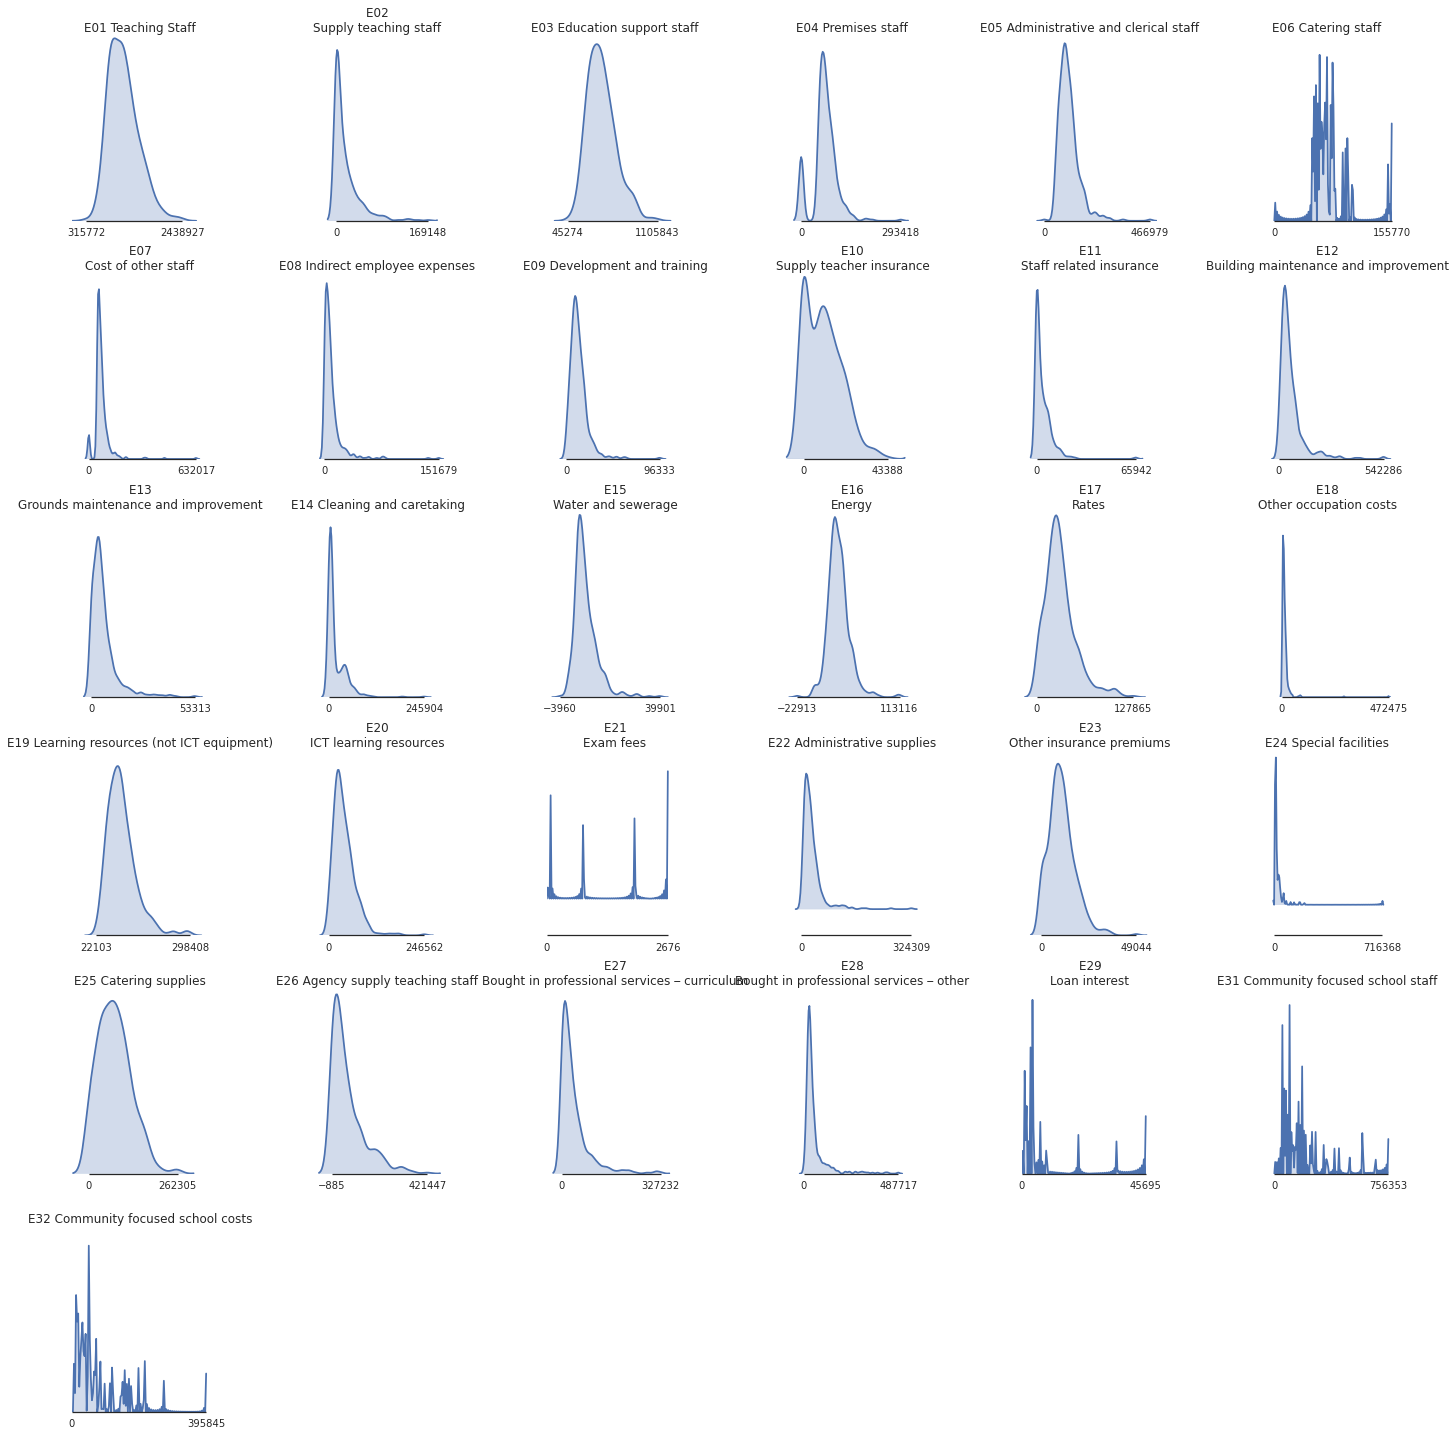

In [7]:
import math

sns.set_style("white")

num_plots = len(input_cols)
n = int(math.ceil(math.sqrt(num_plots)))

fig = plt.figure(figsize=(20, 20))
axes = [plt.subplot(n, n, i) for i in range(1, num_plots + 1)]

i = 0
for k, v in inoutdat[input_cols].iteritems():
    ax = axes[i]
    sns.kdeplot(v, shade=True, ax=ax, legend=False)
    [label.set_visible(False) for label in ax.get_yticklabels()]
    ax.xaxis.set_ticks([v.min(), v.max()])
    ax.set_title(k)
    i += 1
sns.despine(left=True, trim=True, fig=fig)
plt.tight_layout()

#### Correlation between inputs

There are too many inputs so check for highly correlated inputs and drop them.

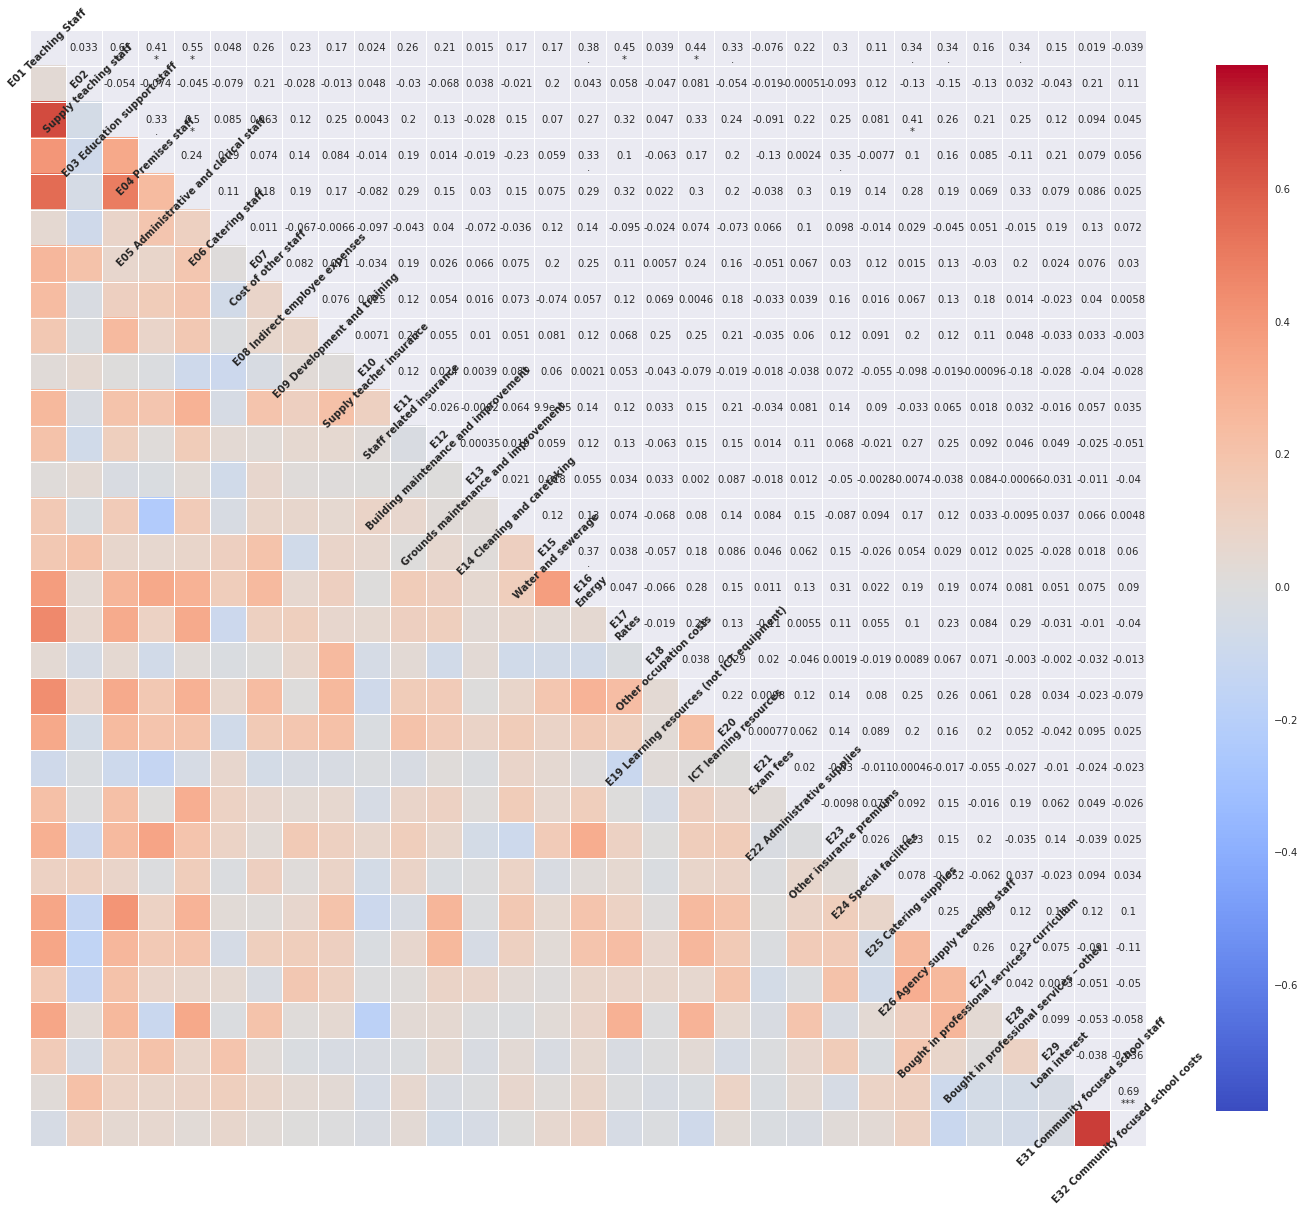

In [8]:
sns.set()
with sns.plotting_context(rc={"figure.figsize": (25, 25),
                              "axis.labelsize": 6}):
    sns.corrplot(inoutdat[input_cols])

Correlations don't appear to be strong so this isn't going to be a productive strategy. Can I drop inputs that have a very low value?

#### Sort inputs by size

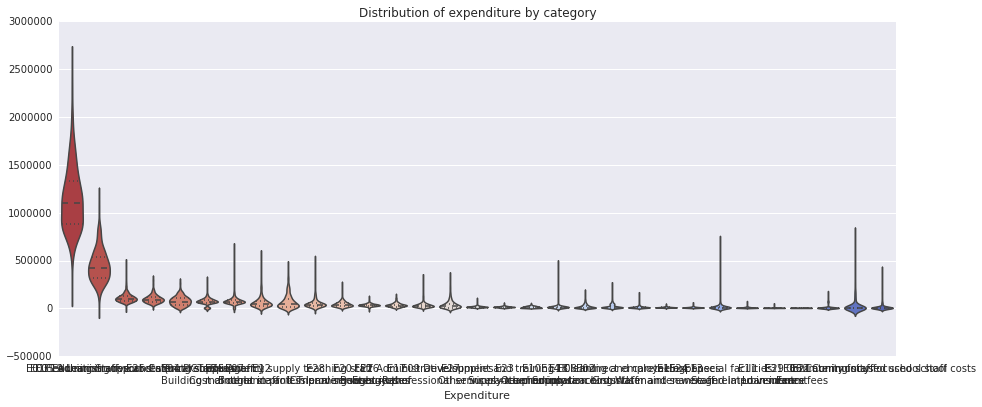

In [9]:
med = inoutdat[input_cols].median()
med.sort(ascending=False)
with sns.plotting_context(rc={"figure.figsize": (15, 6)}):
    sns.violinplot(inoutdat[med.index], color="coolwarm_r")
plt.xlabel("Expenditure")
plt.title("Distribution of expenditure by category")
sns.despine()

Clearly not many of these costs are significant. Picking the top five:

In [10]:
med.index[:5].values

array(['E01 Teaching Staff', 'E03 Education support staff',
       'E05 Administrative and clerical staff',
       'E19 Learning resources (not ICT equipment)',
       'E25 Catering supplies'], dtype=object)

In [11]:
totin = inoutdat[input_cols].sum().sum()
inoutdat[med.index[:5].values].sum().div(totin)

E01 Teaching Staff                            0.450038
E03 Education support staff                   0.175632
E05 Administrative and clerical staff         0.042547
E19 Learning resources (not ICT equipment)    0.038280
E25 Catering supplies                         0.029932
dtype: float64

In [12]:
inoutdat[med.index[:5].values].sum().div(totin).cumsum()

E01 Teaching Staff                            0.450038
E03 Education support staff                   0.625670
E05 Administrative and clerical staff         0.668218
E19 Learning resources (not ICT equipment)    0.706498
E25 Catering supplies                         0.736430
dtype: float64

The top five account for less the three-quarters of the total expenditure so this isn't ideal. It might be worth trying a PCA approach later by way of comparison.

### Set up and solve the DEA problem

In [13]:
%%time
primDEA = dea.DEAProblem(inoutdat[med.index[:5]], inoutdat[output_cols], returns='CRS')

Wall time: 3min 35s


In [14]:
%%time
primResults = primDEA.solve()

Wall time: 2min 56s


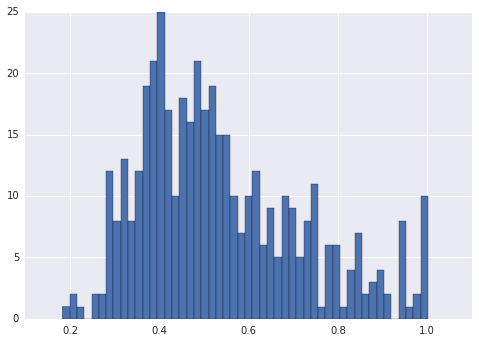

In [22]:
primResults['Efficiency'].hist(bins=50)

That's a good spread but the inputs are very limited. Could we use PCA to limit them instead of truncating at the biggest five?

## PCA analysis of the inputs and outputs

Aim for components that explain at least 80 per cent of the variation in the target variables. Jollife (1972) also suggest only using components with eigenvalues greater than 0.7.

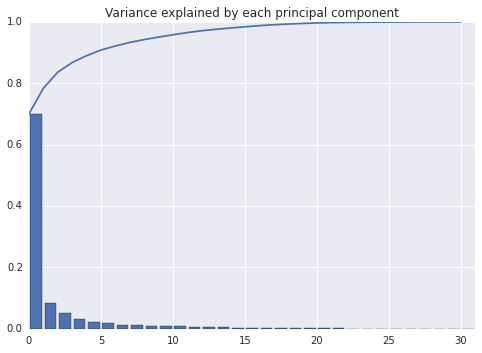

In [24]:
indat_pca = dea.tools.deaPCA(inoutdat[input_cols])

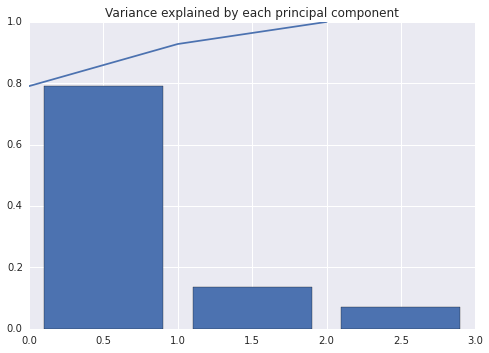

In [25]:
outdat_pca = dea.tools.deaPCA(inoutdat[output_cols])

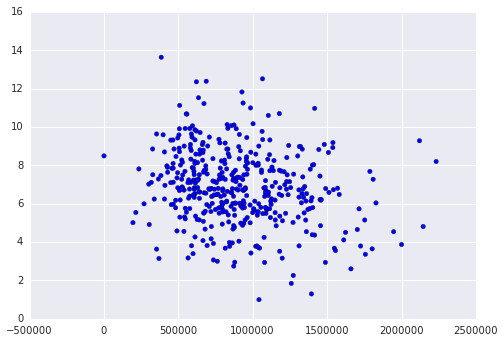

In [26]:
plt.scatter(indat_pca[0].values, outdat_pca[0].values)

In [27]:
%%time
pcaDEA = dea.DEAProblem(indat_pca.iloc[:,:2], outdat_pca.iloc[:,:2], returns='CRS')

Wall time: 2min 11s


In [28]:
%%time
pcaResults = pcaDEA.solve()

Wall time: 2min 43s


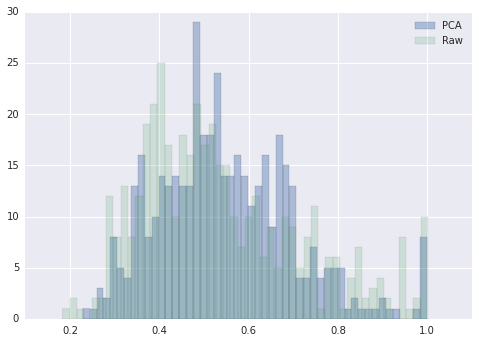

In [29]:
fig1, ax1 = plt.subplots()
pcaResults['Efficiency'].hist(bins=50, ax=ax1, alpha=0.4)
primResults['Efficiency'].hist(bins=50, ax=ax1, alpha=0.2)
plt.legend(['PCA', 'Raw'])

There doesn't seem to be any good reason to prefer 